In [1]:
import spacy
import json
import re
import altair as alt
import pandas as pd

Oids to revise:
- 108532 mitigation
- 80048 No solution
- 14611 Solution is not into the block of text
- 19304
- 10675 Mal clasificado
- 11036 Mal clasificado

In [2]:
#nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_lg") # Changed for this model because it has more vocabulary than the other one
with open('OpenvasLookup.json') as dataset_input:
    data = json.load(dataset_input)

### Convert text to lowercase

In [3]:
#position = 13000 # Mejor limpieza que he visto
position = 10000
#position = 10001 # No solution example
text = data[position]['text']
print(text)

script_oid("1.3.6.1.4.1.25623.1.0.120205");
  script_version("$Revision: 11711 $");
  script_tag(name:"creation_date", value:"2015-09-08 13:20:06 +0200 (Tue, 08 Sep 2015)");
  script_tag(name:"last_modification", value:"$Date: 2018-10-01 14:30:57 +0200 (Mon, 01 Oct 2018) $");
  script_name("Amazon Linux Local Check: ALAS-2014-328");
  script_tag(name:"insight", value:"Multiple flaws were found in the Linux kernel. Please see the references for more information.");
  script_tag(name:"solution", value:"Run yum update kernel to update your system.  You will need to reboot your system in order for the new kernel to be running.");
  script_tag(name:"solution_type", value:"VendorFix");
  script_xref(name:"URL", value:"https://alas.aws.amazon.com/ALAS-2014-328.html");
  script_cve_id("CVE-2014-2309", "CVE-2014-0077", "CVE-2014-2523", "CVE-2014-0055");
  script_tag(name:"cvss_base", value:"10.0");
  script_tag(name:"cvss_base_vector", value:"AV:N/AC:L/Au:N/C:C/I:C/A:C");
  script_tag(name:"qod

### Remove numbers

In [4]:
def clean_text(text):
    text = re.sub(r'(script_oid|SCRIPT\_OID).*?\".*?\.(?P<oid>\d+)\"', '',text)
    text = re.sub(r'script\_family\(\"(?P<script_family>.*?)\"\)', '',text)
    text = re.sub(r'script_copyright.*', '', text)
    text = re.sub(r'script_dependencies.*', '', text)
    text = re.sub(r'script_mandatory_keys.*', '', text)
    text = re.sub(r'.*?cvss\_base\_vector.*', '', text)
    text = re.sub(r'script_version.*', '', text)
    text = re.sub(r'.*?last_modification.*', '', text)
    text = re.sub(r'.*?creation_date.*', '', text)
    text = re.sub(';', '' , text)
    text = re.sub('\"', '', text)
    text = re.sub('value\:', '', text)
    text = re.sub('name\:', '', text)
    text = re.sub('\(|\)', ' ', text)
    text = re.sub('if.*?(.*?description.*?)', '', text)
    text = re.sub('.*?script_xref.*', '', text)
    #text = re.sub('cve-\d+\-\d+', '', text)
    #text = re.sub('.*?script\_cve\_id.*', '', text)
    text = re.sub(',', '', text)
    return text
cleaned_text = clean_text(text)
print(cleaned_text)

 
  


  script_name Amazon Linux Local Check: ALAS-2014-328 
  script_tag insight Multiple flaws were found in the Linux kernel. Please see the references for more information. 
  script_tag solution Run yum update kernel to update your system.  You will need to reboot your system in order for the new kernel to be running. 
  script_tag solution_type VendorFix 

  script_cve_id CVE-2014-2309 CVE-2014-0077 CVE-2014-2523 CVE-2014-0055 
  script_tag cvss_base 10.0 

  script_tag qod_type package 
  
  
  script_category ACT_GATHER_INFO 
  script_tag summary Amazon Linux Local Security Checks 
  
  


In [5]:
stopwords = spacy.lang.en.STOP_WORDS
try:
    stopwords.remove('no')
    stopwords.remove('not')# We need the word "NO" for vulns that don't have solution
    stopwords.add('script_tag')
    stopwords.add('script_xref')
except:
    pass

In [6]:
doc = nlp(cleaned_text)
#text_without_stopped_words = [tok.text for tok in doc if (tok.text not in stopwords and tok.pos_ != "PUNCT" and tok.pos_ != "SYM")]
#final_tokenized_words = map(str.rstrip, text_without_stopped_words)
#final_tokenized_words = filter(None, list(final_tokenized_words))
#final_tokenized_words = list(final_tokenized_words)

#print(final_tokenized_words)

I don't like the way Spacy tokenized the CVE's so I decided to created a new pattern

In [7]:
for token in doc[0:10]:
    print(token,token.lemma_,token.is_stop)

 
  


    
  


   False
script_name script_name False
Amazon Amazon False
Linux Linux False
Local Local False
Check Check False
: : False
ALAS-2014 alas-2014 False
- - False
328 328 False


In [8]:
from spacy.tokenizer import Tokenizer
def custom_tokenizer(nlp,regex):
    prefix_re = re.compile(regex)
    return Tokenizer(nlp.vocab, prefix_search = prefix_re.search)
nlp.tokenizer = custom_tokenizer(nlp,r'cve\-\d+\-\d+')

In [9]:
doc = nlp(cleaned_text)
type(doc)

spacy.tokens.doc.Doc

In [10]:
for tokens in doc[0:10]:
    print(tokens)

 
  


  
script_name
Amazon
Linux
Local
Check:
ALAS-2014-328

  
script_tag
insight


In [11]:
# Removing Stop words
doc = nlp(cleaned_text)
#tokens = [token.text for token in doc if not token.is_stop]
text_without_stopped_words = [tok.text for tok in doc if (tok.text not in stopwords and tok.pos_ != "PUNCT" and tok.pos_ != "SYM")]
final_tokenized_words = map(str.rstrip, text_without_stopped_words)
final_tokenized_words = filter(None, list(final_tokenized_words))
final_tokenized_words = list(final_tokenized_words)

In [12]:
doc = nlp.tokenizer.tokens_from_list(final_tokenized_words)
nlp.tagger(doc)
nlp.parser(doc)
print(doc.text.split())

['script_name', 'Amazon', 'Linux', 'Local', 'Check:', 'insight', 'Multiple', 'flaws', 'found', 'Linux', 'kernel.', 'Please', 'references', 'information.', 'solution', 'Run', 'yum', 'update', 'kernel', 'update', 'system.', 'You', 'need', 'reboot', 'system', 'order', 'new', 'kernel', 'running.', 'solution_type', 'VendorFix', 'script_cve_id', 'CVE-2014-2309', 'CVE-2014-0077', 'CVE-2014-2523', 'CVE-2014-0055', 'cvss_base', '10.0', 'qod_type', 'package', 'script_category', 'ACT_GATHER_INFO', 'summary', 'Amazon', 'Linux', 'Local', 'Security', 'Checks']


In [13]:
from collections import Counter
counts = Counter(doc.text.split())
#counts = Counter(final_tokenized_words)
counts = dict(counts)
print(counts)

{'script_name': 1, 'Amazon': 2, 'Linux': 3, 'Local': 2, 'Check:': 1, 'insight': 1, 'Multiple': 1, 'flaws': 1, 'found': 1, 'kernel.': 1, 'Please': 1, 'references': 1, 'information.': 1, 'solution': 1, 'Run': 1, 'yum': 1, 'update': 2, 'kernel': 2, 'system.': 1, 'You': 1, 'need': 1, 'reboot': 1, 'system': 1, 'order': 1, 'new': 1, 'running.': 1, 'solution_type': 1, 'VendorFix': 1, 'script_cve_id': 1, 'CVE-2014-2309': 1, 'CVE-2014-0077': 1, 'CVE-2014-2523': 1, 'CVE-2014-0055': 1, 'cvss_base': 1, '10.0': 1, 'qod_type': 1, 'package': 1, 'script_category': 1, 'ACT_GATHER_INFO': 1, 'summary': 1, 'Security': 1, 'Checks': 1}


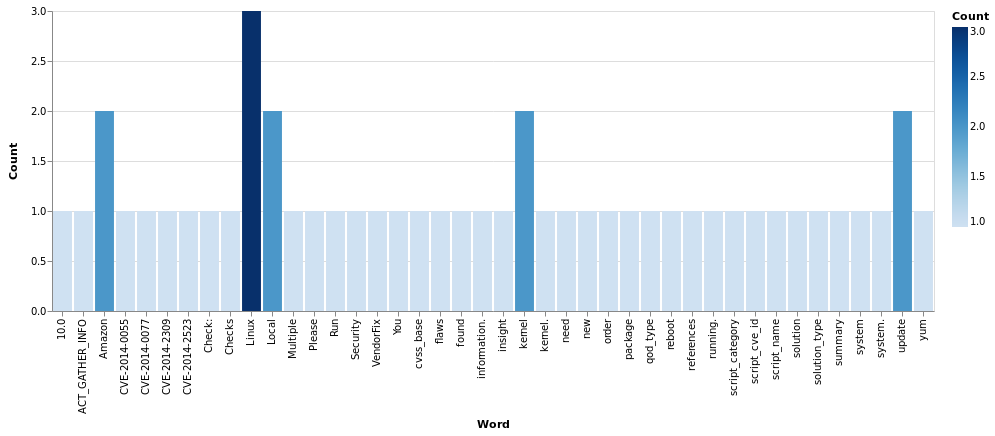

In [29]:
df_words = pd.DataFrame(counts.items(), columns=['Word','Count'])
source = df_words
alt.Chart(source).mark_bar().encode(
    alt.X('Word'),
    y='Count',
    color='Count'
)

In [15]:
text_list = []
lemma_list = []
pos_list = []
is_stop_list =[] 
has_vector_list = []
out_of_voc_list = []
for token in doc:
    text_list.append(token.text)
    lemma_list.append(token.lemma_)
    pos_list.append(token.pos_)
    is_stop_list.append(token.is_stop)
    has_vector_list.append(token.has_vector)
    out_of_voc_list.append(token.is_oov)
    
doc_dictionary = {"Text": text_list , "Lemma": lemma_list, 
                  "Pos": pos_list , "Stop": is_stop_list, 
                  "HasVector": has_vector_list, "OutOfVocabulary": out_of_voc_list}
token_df = pd.DataFrame(doc_dictionary)

In [16]:
token_df[token_df['Text'] == 'update'] ## In this case the word update is a noun and not a verb

Text   Lemma   Pos   Stop  HasVector  OutOfVocabulary
17  update  update  NOUN  False       True            False
19  update  update  NOUN  False       True            False

In [17]:
token_df[token_df['Text'] == 'VendorFix'] # In this case the word updated is a VERB

Text      Lemma    Pos   Stop  HasVector  OutOfVocabulary
30  VendorFix  VendorFix  PROPN  False      False             True

In [18]:
token_df[token_df['Text'] == 'QEMU']

Empty DataFrame
Columns: [Text, Lemma, Pos, Stop, HasVector, OutOfVocabulary]
Index: []

In [19]:
#token_df = token_df.replace('\n','', regex=True)
cleaned_token = token_df[token_df['Pos'] != "SPACE"]
cleaned_token.head(5)

Text        Lemma    Pos   Stop  HasVector  OutOfVocabulary
0  script_name  script_name  PROPN  False      False             True
1       Amazon       Amazon  PROPN  False       True            False
2        Linux        Linux  PROPN  False       True            False
3        Local        Local  PROPN  False       True            False
4       Check:       Check:  PROPN  False      False             True

In [20]:
grouped_token = cleaned_token[['Lemma','Pos','OutOfVocabulary']].groupby(['Pos','OutOfVocabulary']).count().reset_index()
grouped_token.head(5)

Pos  OutOfVocabulary  Lemma
0   ADJ            False      2
1  INTJ            False      1
2  NOUN            False     16
3  NOUN             True      2
4   NUM            False      1

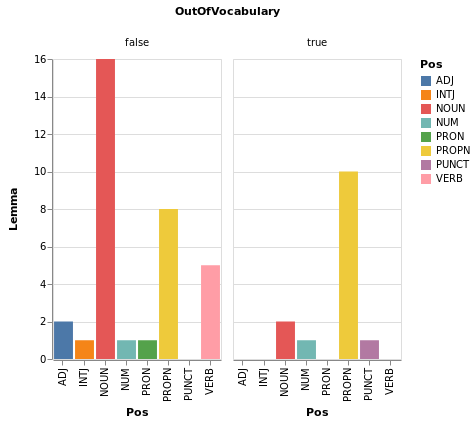

In [21]:
alt.Chart(grouped_token).mark_bar().encode(
    x='Pos',
    y='Lemma',
    color='Pos',
    column='OutOfVocabulary'
)

In [22]:
doc.similarity(nlp('no solution'))

0.6449094981275274

In [23]:
doc.similarity(nlp('fix'))

0.6649761454673645

In [24]:
for token in nlp('Need a fix for laptop'):
    print(token.lemma_,token.pos_, token.is_oov)

need VERB False
a DET False
fix NOUN False
for ADP False
laptop NOUN False


In [25]:
for token in nlp('VendorFix'):
    print(token.lemma_, token.pos_, token.is_oov)

VendorFix PROPN True


In [26]:
doc = nlp("Cloud computing is benefiting major manufacturing companies")
list(doc.noun_chunks)

[Cloud computing, major manufacturing companies]

In [27]:
list(nlp('VendorFix'))

[VendorFix]

In [30]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)
# Add match ID "HelloWorld" with no callback and one pattern
pattern = [{'LOWER': 'vendorfix'}]
matcher.add("VendorFix", None, pattern)

doc = nlp(u"VendorFix")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

6112308148154885510 VendorFix 0 1 VendorFix
